In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
from itertools import product
from tqdm import tqdm_notebook
#Holt-Winters

In [3]:
#data = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_time_series_for_forecasting.json')
#data = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_time_series_for_forecasting_Tampa_Tucson.json')
data = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_time_series_for_forecasting_Indianapolis_Reno_Santa_Barbara_Saint_Louis_Boise.json')

In [4]:
forecast_df = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville_Tampa_Tucson.json')

In [5]:
start_idx = 0
split_idx = 418
end_idx = len(data)
data_type = 'count'

In [6]:
def train_test_split(data, city, start_idx, split_idx, end_idx):
    df = data[data.filter(like= city).columns]
    df['date'] = pd.to_datetime(data['date'])
    train_df = df.drop(range(split_idx,end_idx), axis = 0)
    test_df = df.drop(range(start_idx,split_idx), axis = 0)
    return df, train_df, test_df

In [7]:
def plot_data(df, data_type, city):
    plt.plot(df['date'], df['{}_{}'.format(data_type, city)])
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Review Volume', fontsize=12)

In [8]:
def tes_optimizer_grid_search(train, abg, data_type, city, trend_mode='add', seasonal_mode = 'add', seasonal_period=52):
    """
        This function to optimize hyperparameters for the TES model
    """
    best_alpha, best_beta, best_gamma, best_rmse, best_mape = None, None, None, float("inf"), float("inf")
    for comb in tqdm_notebook(abg):
        # 5 fold cv
        tscv = TimeSeriesSplit()
        for i, j in tscv.split(train):
            X_train = train_df['{}_{}'.format(data_type, city)].iloc[i]
            X_val =  train_df['{}_{}'.format(data_type, city)].iloc[j]
        model = ExponentialSmoothing(X_train, trend=trend_mode, seasonal=seasonal_mode
                                         , seasonal_periods=seasonal_period).fit(smoothing_level=comb[0]
                                                                                 , smoothing_trend=comb[1]
                                                                                 , smoothing_seasonal=comb[2])
        
        y_pred = model.forecast(len(X_val))
        rmse = mean_squared_error(X_val, y_pred, squared=False)
        mape = mean_absolute_percentage_error(X_val, y_pred)
        if (mape < best_mape) & (rmse < best_rmse):
            best_alpha, best_beta, best_gamma, best_rmse, best_mape = comb[0], comb[1], comb[2], rmse, mape
        #print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(rmse, 2), round(mape, 4)])
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
              "best_rmse:", round(best_rmse, 4), "best_mape:", round(best_mape, 4))
    return best_alpha, best_beta, best_gamma, best_rmse, best_mape

In [9]:
def generate_grid(start, end, step):
    alphas = betas = gammas = np.arange(start, end, step)
    abg = list(product(alphas, betas, gammas))
    return abg

In [10]:
def get_forecast(alpha, beta, gamma, steps, city, train_df, data):
    model = ExponentialSmoothing(train_df['{}_{}'.format(data_type, city)],
                             trend="add",
                             seasonal="add",
                             seasonal_periods=52
                            ).fit(smoothing_level=alpha,
                                  smoothing_trend=beta,
                                  smoothing_seasonal=gamma)
    y_pred = model.forecast(len(test_df))
    train_df['predicted_{}'.format(city)] = np.NaN
    forecast = data.copy()
    forecast['predicted_{}'.format(city)] = train_df['predicted_{}'.format(city)].append(y_pred)
    return y_pred, forecast

In [11]:
def plot_forecast(df, data_type, city):
    plt.plot(forecast['date'], forecast['{}_{}'.format(data_type, city)],label='{}_{}'.format(data_type, city))
    plt.plot(forecast['date'], forecast['predicted_{}'.format(city)], label='predicted_{}'.format(data_type, city))
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Review Volume', fontsize=12)
    plt.legend()
    plt.show()

In [12]:
def print_evaluation_metric(test_df, data_type, city, y_pred):
    rmse = mean_squared_error(test_df['{}_{}'.format(data_type, city)], y_pred, squared=False)
    mape = mean_absolute_percentage_error(test_df['{}_{}'.format(data_type, city)], y_pred)
    print('RMSE: ', rmse)
    print('MAPE: ', mape)

In [13]:
def save_prediction(y_pred, df, train_df, forecast_df, city):
    train_df['predicted_{}'.format(city)] = np.NaN
    forecast = df.copy()
    forecast['predicted_{}_count_Holt-Winters'.format(city)] = train_df['predicted_{}'.format(city)].append(y_pred)
    forecast_df['predicted_{}_count_Holt-Winters'.format(city)] = forecast['predicted_{}_count_Holt-Winters'.format(city)]
    return forecast_df

# Philadelphia

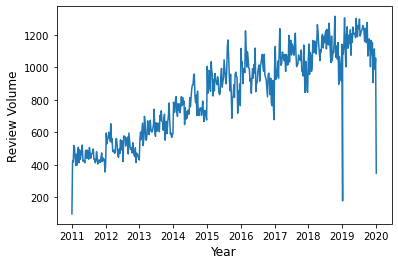

In [42]:
city = 'Philadelphia'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [44]:
abg = generate_grid(0.02, 1, 0.02)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

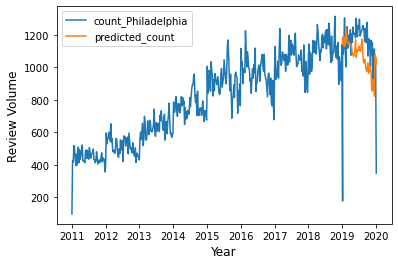

In [45]:
y_pred, forecast = get_forecast(0.14, 0.1, 0.1, steps, city, train_df, data)
plot_forecast(forecast, data_type, city)

In [46]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  216.00771937570877
MAPE:  0.2390812369537269


In [47]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)

# New Orleans

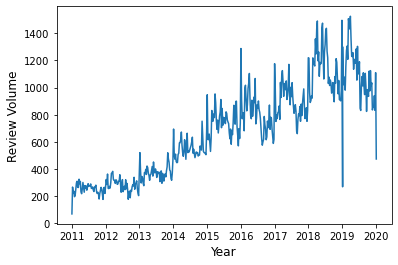

In [50]:
city = 'New Orleans'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [52]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

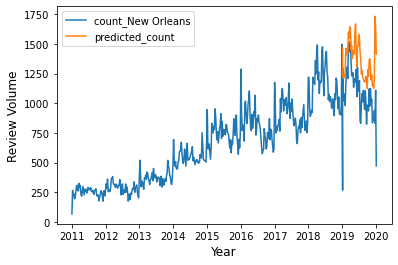

In [53]:
y_pred, forecast = get_forecast(0.02, 0.1, 0.62, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [54]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  359.757342230189
MAPE:  0.36155709553467097


In [55]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)

# Nashville

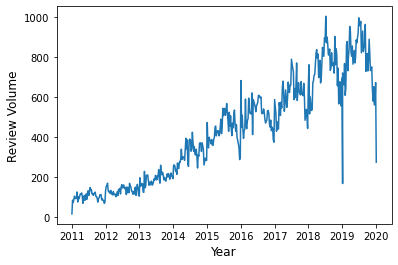

In [56]:
city = 'Nashville'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [58]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

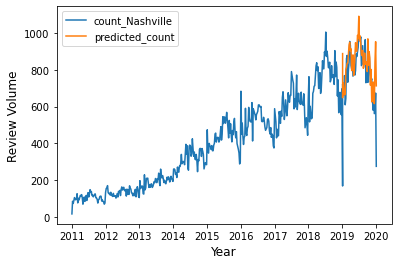

In [59]:
y_pred, forecast = get_forecast(0.06, 0.1, 0.94, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [60]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  148.27024263089973
MAPE:  0.2030030995246107


In [61]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)

In [63]:
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

In [64]:
forecast_df.to_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville.json')

# Tampa

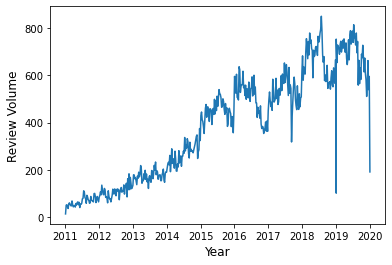

In [63]:
city = 'Tampa'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [65]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

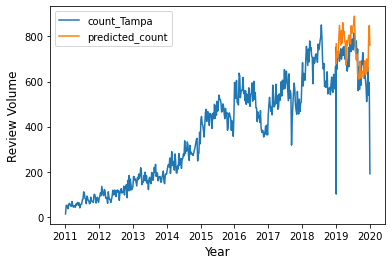

In [66]:
y_pred, forecast = get_forecast(0.1, 0.02, 0.86, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [67]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  149.5663685228637
MAPE:  0.2866057650238973


In [68]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)

In [69]:
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

In [ ]:
# forecast_df.to_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville.json')

# Tucson

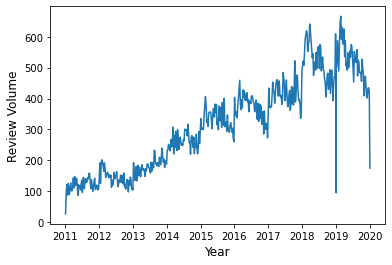

In [70]:
city = 'Tucson'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [20]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

  0%|          | 0/15625 [00:00<?, ?it/s]

best_alpha: 0.02 best_beta: 0.58 best_gamma: 0.26 best_rmse: 49.3981 best_mape: 0.0796


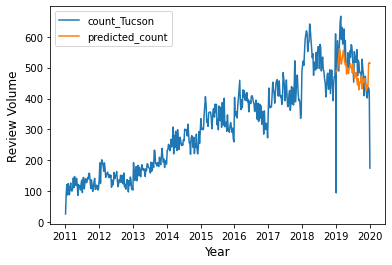

In [71]:
y_pred, forecast = get_forecast(0.02, 0.58, 0.26, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [72]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  90.44714638478253
MAPE:  0.199217440312176


In [73]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)

In [74]:
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

In [76]:
forecast_df.to_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville_Tampa_Tucson.json')

# Indianapolis

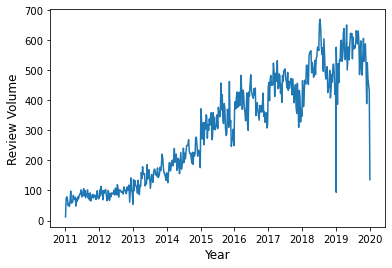

In [14]:
city = 'Indianapolis'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

  0%|          | 0/15625 [00:00<?, ?it/s]

best_alpha: 0.18 best_beta: 0.78 best_gamma: 0.02 best_rmse: 59.4389 best_mape: 0.0985


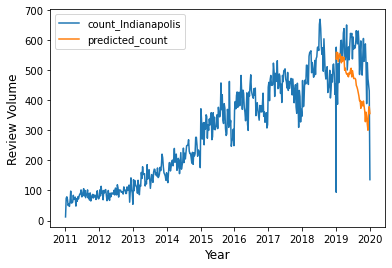

In [16]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)
y_pred, forecast = get_forecast(best_alpha, best_beta, best_gamma, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [17]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  141.32669469791563
MAPE:  0.309236357949896


In [18]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

# Reno

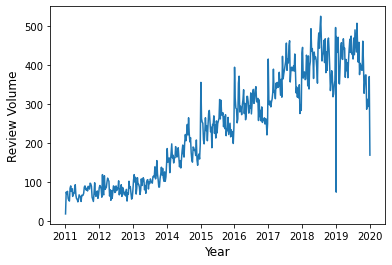

In [19]:
city = 'Reno'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [ ]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

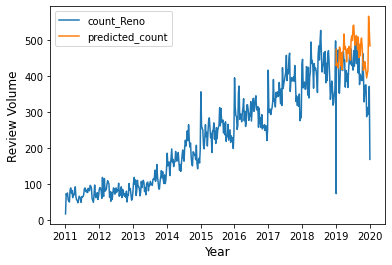

In [20]:
y_pred, forecast = get_forecast(0.02, 0.02, 0.5, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [21]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  105.09541760846236
MAPE:  0.29789831770528336


In [22]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

# Santa Barbara

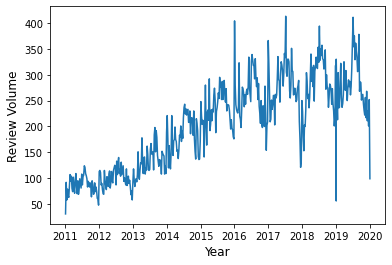

In [23]:
city = 'Santa Barbara'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [ ]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

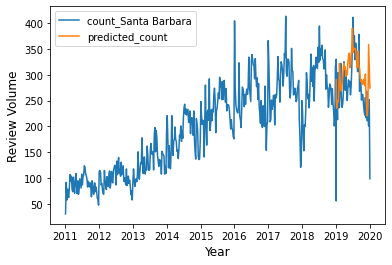

In [24]:
y_pred, forecast = get_forecast(0.02, 0.06, 0.3, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [25]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  60.74668466806585
MAPE:  0.24904907506523302


In [26]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

# Saint Louis

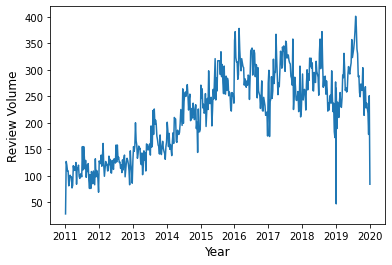

In [27]:
city = 'Saint Louis'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [ ]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

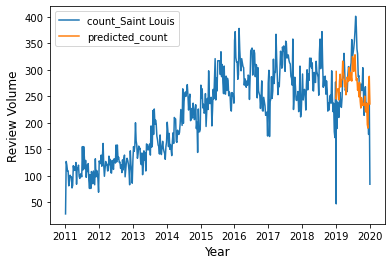

In [28]:
y_pred, forecast = get_forecast(0.02, 0.06, 0.34, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [29]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  56.968644689272
MAPE:  0.24899093979836268


In [30]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

# Boise

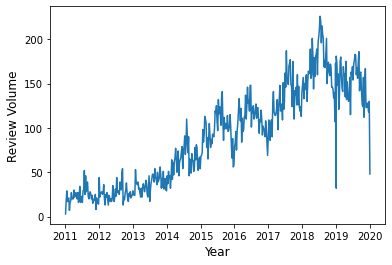

In [31]:
city = 'Boise'
df, train_df, test_df = train_test_split(data, city, start_idx, split_idx, end_idx)
steps = len(test_df)

plot_data(df, data_type, city)

In [ ]:
abg = generate_grid(0.02, 1, 0.04)
best_alpha, best_beta, best_gamma, best_rmse, best_mape = tes_optimizer_grid_search(train_df['{}_{}'.format(data_type, city)], abg, data_type, city)

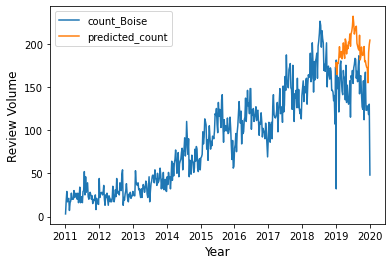

In [32]:
y_pred, forecast = get_forecast(0.06, 0.02, 0.38, steps, city, train_df, data)

plot_forecast(forecast, data_type, city)

In [33]:
print_evaluation_metric(test_df, data_type, city, y_pred)

RMSE:  55.11954374478074
MAPE:  0.435045126038839


In [34]:
forecast_df = save_prediction(y_pred, data, train_df, forecast_df, city)
forecast_df.columns

Index(['date', 'count_Philadelphia', 'bsi_Philadelphia_stars',
       'asi_Philadelphia_stars', 'vsi_Philadelphia_stars', 'count_New Orleans',
       'bsi_New Orleans_stars', 'asi_New Orleans_stars',
       'vsi_New Orleans_stars', 'count_Nashville', 'bsi_Nashville_stars',
       'asi_Nashville_stars', 'vsi_Nashville_stars',
       'bsi_Philadelphia_stars_bert_512', 'bsi_Philadelphia_stars_roberta_512',
       'bsi_New Orleans_stars_bert_512', 'bsi_New Orleans_stars_roberta_512',
       'bsi_Nashville_stars_bert_512', 'bsi_Nashville_stars_roberta_512',
       'asi_Philadelphia_stars_bert_512', 'asi_Philadelphia_stars_roberta_512',
       'asi_New Orleans_stars_bert_512', 'asi_New Orleans_stars_roberta_512',
       'asi_Nashville_stars_bert_512', 'asi_Nashville_stars_roberta_512',
       'vsi_Philadelphia_stars_bert_512', 'vsi_Philadelphia_stars_roberta_512',
       'vsi_New Orleans_stars_bert_512', 'vsi_New Orleans_stars_roberta_512',
       'vsi_Nashville_stars_bert_512', 'vsi_Nashvil

In [35]:
forecast_df.to_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville_Tampa_Tucson_Indianapolis_Reno_Santa_Barbara_Saint_Louis_Boise.json')